![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 16 - GAN </center>
### <center> Vanilla GAN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/16_GAN/MainGAN.ipynb)

In [1]:
#-- Wide screen :
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install torchinfo

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision.transforms as transforms
import torchinfo

torch.backends.cudnn.benchmark = True

#### Load MNIST data:

In [4]:
import torchvision.transforms as transforms
import torchvision

dataPath   = r'../../data/'
oTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
oTrainSet  = torchvision.datasets.MNIST(root=dataPath, train=True, transform=oTransform, download=True)

In [5]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True, batch_size=batchSize, num_workers=2, persistent_workers=True, drop_last=True)

mX,       vY = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/16_GAN/VanillaGAN.png?raw=true" width=800>

#### GAN Generator:

In [6]:
class Generator(nn.Module):
    def __init__(self, D):
        super().__init__()
        
        self.D    = D
        self.oGen = nn.Sequential(
            nn.Identity(),
            nn.Linear(D, 64*7*7, bias=False), nn.Unflatten(1, (64, 7, 7)),       nn.BatchNorm2d(64), nn.ReLU(),

            nn.Upsample(scale_factor=2), nn.Conv2d(64, 32, 3, 2, 1, bias=False), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.Conv2d(32, 16, 3, 1, 1, bias=False), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.Conv2d(16, 8,  3, 1, 1, bias=False), nn.BatchNorm2d(8 ), nn.ReLU(),
                                         nn.Conv2d(8,  1,  3, 1, 1, bias=False),                     nn.Tanh(),
        )
        
    def forward(self, mZ):
        mHatX = self.oGen(mZ)
            
        return mHatX
#=============================================================#
#=============================================================#
D = 16
torchinfo.summary(Generator(D), (mX.shape[0], D))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [128, 1, 28, 28]          --
│    └─Identity: 2-1                     [128, 16]                 --
│    └─Linear: 2-2                       [128, 3136]               50,176
│    └─Unflatten: 2-3                    [128, 64, 7, 7]           --
│    └─BatchNorm2d: 2-4                  [128, 64, 7, 7]           128
│    └─ReLU: 2-5                         [128, 64, 7, 7]           --
│    └─Upsample: 2-6                     [128, 64, 14, 14]         --
│    └─Conv2d: 2-7                       [128, 32, 7, 7]           18,432
│    └─BatchNorm2d: 2-8                  [128, 32, 7, 7]           64
│    └─ReLU: 2-9                         [128, 32, 7, 7]           --
│    └─Upsample: 2-10                    [128, 32, 14, 14]         --
│    └─Conv2d: 2-11                      [128, 16, 14, 14]         4,608
│  

#### GAN discriminator:

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.oDis = nn.Sequential(
            nn.Identity(),
            nn.Conv2d  (1,  8 , 3, 2, 1), nn.BatchNorm2d(8),  nn.LeakyReLU(.2),
            nn.Conv2d  (8,  16, 3, 2, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            nn.Conv2d  (16, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(.2),
            nn.Conv2d  (32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(.2),
            nn.Flatten (),
            nn.Linear  (256, 1),
        )
        
    def forward(self, mX):
        vOut = self.oDis(mX).view(-1)
    
        return vOut
#=============================================================#
#=============================================================#
print(torchinfo.summary(Discriminator(), mX.shape))

vOut = Discriminator()(mX)
vOut.shape

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [128, 1]                  --
│    └─Identity: 2-1                     [128, 1, 28, 28]          --
│    └─Conv2d: 2-2                       [128, 8, 14, 14]          80
│    └─BatchNorm2d: 2-3                  [128, 8, 14, 14]          16
│    └─LeakyReLU: 2-4                    [128, 8, 14, 14]          --
│    └─Conv2d: 2-5                       [128, 16, 7, 7]           1,168
│    └─BatchNorm2d: 2-6                  [128, 16, 7, 7]           32
│    └─LeakyReLU: 2-7                    [128, 16, 7, 7]           --
│    └─Conv2d: 2-8                       [128, 32, 4, 4]           4,640
│    └─BatchNorm2d: 2-9                  [128, 32, 4, 4]           64
│    └─LeakyReLU: 2-10                   [128, 32, 4, 4]           --
│    └─Conv2d: 2-11                      [128, 64, 2, 2]           18,496
│    

torch.Size([128])

#### Epoch:
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/16_GAN/VanillaGAN.png?raw=true" width=800>

* Discriminator:
$$\max_{\psi}\frac{1}{N}\sum_{i=1}^{N}\log\left(D_{\psi}\left(\boldsymbol{x}_{i}\right)\right)+\log\left(1-D_{\psi}\left(G_{\theta}\left(\boldsymbol{z}_{i}\right)\right)\right)$$
* Generator:
$$\max_{\theta}\frac{1}{N}\sum_{i=1}^{N}\log\left(D_{\psi}\left(G_{\theta}\left(\boldsymbol{z}_{i}\right)\right)\right)$$

In [8]:
def Epoch(oG, oD, oDataDL, Loss, oOptimG, oOptimD, oSchedulerG, oSchedulerD):

    epochLossReal = 0
    epochLossFake = 0
    epochAccReal  = 0
    epochAccFake  = 0
    count         = 0
    nIter         = len(oDataDL)
    vLR           = np.full(nIter, np.nan)
    
    DEVICE        = next(oG.parameters()).device #-- CPU\GPU
    Nb            = oDataDL.batch_size
    vOnes         = torch.ones (Nb, device=DEVICE)
    vZeros        = torch.zeros(Nb, device=DEVICE)
    vY            = torch.cat  ([vOnes, vZeros])
    
    oG.train(True)
    oD.train(True)

    #-- Iterate over the mini-batches:
    for ii, (mX, _) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mReal = mX.to(DEVICE)
        mZ    = torch.randn(Nb, oG.D, device=DEVICE)

        #==Train D==============================================#
        for param in oD.parameters():
            param.requires_grad = True
            
        mFake       = oG  (mZ)
        vLogitsReal = oD  (mReal)
        vLogitsFake = oD  (mFake.detach())
        lossReal    = Loss(vLogitsReal, vOnes)
        lossFake    = Loss(vLogitsFake, vZeros)
        lossD       = (lossReal + lossFake) / 2
        
        #-- Backward:
        oOptimD    .zero_grad()
        lossD      .backward ()
        oOptimD    .step     ()
        oSchedulerD.step     ()
        #=======================================================#
        
        #==Train G (with fake data)=============================#
        for param in oD.parameters():
            param.requires_grad = False
            
        vLogitsG = oD(mFake)
        lossG    = Loss(vLogitsG, vOnes)
        
        #-- Backward:
        oOptimG    .zero_grad()
        lossG      .backward ()
        oOptimG    .step     ()
        oSchedulerG.step     ()
        #=======================================================#
 
        with torch.no_grad():
            lossReal = torch.sigmoid(vLogitsReal).mean().item()
            lossFake = torch.sigmoid(vLogitsFake).mean().item()

            count         += Nb
            epochLossReal += Nb * lossReal
            epochLossFake += Nb * lossFake
            epochAccReal  += Nb * torch.mean((vLogitsReal > 0).float()).item()
            epochAccFake  += Nb * torch.mean((vLogitsFake < 0).float()).item()
        print(f'\rIteration: {ii:3d} ({nIter}): D(x) = {lossReal:5.4f}, D(G(z)) = {lossFake:5.4f}', end='')

    print('', end='\r')
    epochLossReal /= count
    epochLossFake /= count
    epochAccReal  /= count
    epochAccFake  /= count

    return epochLossReal, epochLossFake, epochAccReal, epochAccFake

In [9]:
import time

def TrainGAN(oG, oD, oDataDL, Loss, nEpochs, oOptimG, oOptimD, oSchedulerG, oSchedulerD, Epoch=Epoch, sModelName='GAN'):

    vLossReal = np.full(nEpochs, np.nan)
    vLossFake = np.full(nEpochs, np.nan)
    vAccReal  = np.full(nEpochs, np.nan)
    vAccFake  = np.full(nEpochs, np.nan)

    DEVICE  = next(oG.parameters()).device #-- CPU\GPU
    mZ      = torch.randn(100, oG.D, device=DEVICE)
    lFake   = [None] * nEpochs
    
    fig, ax = plt.subplots(figsize=(6, 6))
    for epoch in range(nEpochs):
        startTime                            = time.time()
        lossReal, lossFake, accReal, accFake = Epoch(oG, oD, oDataDL, Loss, oOptimG, oOptimD, oSchedulerG, oSchedulerD)
        epochTime                            = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '               f'{epoch     :03d}:', end='')
        print(' | D(x): '            f'{lossReal  :6.3f}', end='')
        print(' | D(G(z)): '         f'{lossFake  :6.3f}', end='')
        print(' | Accuracy (real): ' f'{accReal   :6.3f}', end='')
        print(' | Accuracy (fake): ' f'{accFake   :6.3f}', end='')
        print(' | Epoch time: '      f'{epochTime :6.3f} |')

        vLossReal[epoch] = lossReal
        vLossFake[epoch] = lossFake
        vAccReal [epoch] = accReal
        vAccFake [epoch] = accFake

        #-- Plot:
        oG.train(False)
        with torch.no_grad():
            mFake        = (oG(mZ).cpu() + 1) / 2
            lFake[epoch] = mFake
        mGrid = torchvision.utils.make_grid(mFake, nrow=10, pad_value=1/2, padding=1)
        mGrid = mGrid.permute(1,2,0)

        ax.cla         ()
        ax.matshow     (mGrid, cmap='gray')
        ax.axis        ('off')
        fig.canvas.draw()
        plt.pause      (1e-2)

    #-- Save the model:
    torch.save(oD.state_dict(), sModelName + '_D.pt')
    torch.save(oG.state_dict(), sModelName + '_G.pt')
        
    return vLossReal, vLossFake, vAccReal, vAccFake, lFake

In [10]:
from torch.optim.lr_scheduler import OneCycleLR

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Loss   = nn.BCEWithLogitsLoss()

### Train the model:

<IPython.core.display.Javascript object>


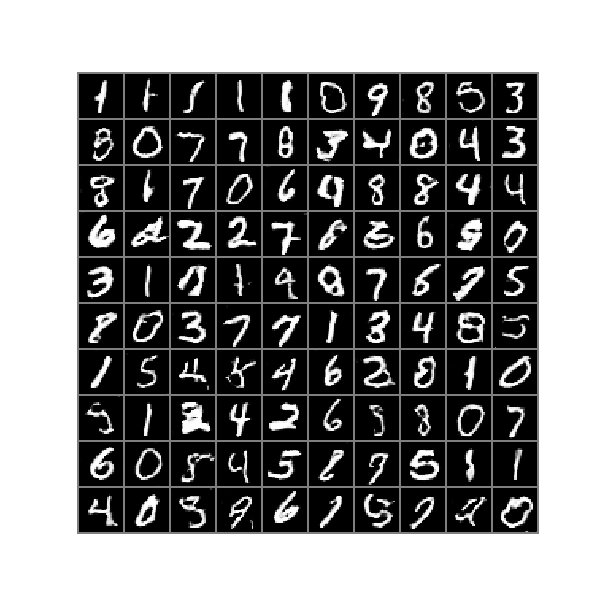

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | D(x):  0.621 | D(G(z)):  0.478 | Accuracy (real):  0.891 | Accuracy (fake):  0.582 | Epoch time:  5.037 |
Epoch 001: | D(x):  0.621 | D(G(z)):  0.391 | Accuracy (real):  0.822 | Accuracy (fake):  0.810 | Epoch time:  4.769 |
Epoch 002: | D(x):  0.677 | D(G(z)):  0.323 | Accuracy (real):  0.838 | Accuracy (fake):  0.855 | Epoch time:  4.733 |
Epoch 003: | D(x):  0.721 | D(G(z)):  0.279 | Accuracy (real):  0.861 | Accuracy (fake):  0.867 | Epoch time:  4.766 |
Epoch 004: | D(x):  0.724 | D(G(z)):  0.278 | Accuracy (real):  0.849 | Accuracy (fake):  0.846 | Epoch time:  4.840 |
Epoch 005: | D(x):  0.739 | D(G(z)):  0.264 | Accuracy (real):  0.881 | Accuracy (fake):  0.884 | Epoch time:  4.877 |
Epoch 006: | D(x):  0.729 | D(G(z)):  0.275 | Accuracy (real):  0.868 | Accuracy (fake):  0.868 | Epoch time:  4.808 |
Epoch 007: | D(x):  0.720 | D(G(z)):  0.281 | 

In [15]:
%matplotlib notebook

D           = 16
nEpochs     = 50
nIter       = nEpochs * len(oTrainDL)

oG          = Generator    (D).to(DEVICE)
oD          = Discriminator() .to(DEVICE)
oOptimG     = optim.Adam   (oG.parameters(), lr=0, betas=(0.5, 0.99))
oOptimD     = optim.Adam   (oD.parameters(), lr=0, betas=(0.5, 0.99))
oSchedulerG = OneCycleLR   (oOptimG, max_lr=1e-3, total_steps=nIter)
oSchedulerD = OneCycleLR   (oOptimD, max_lr=1e-3, total_steps=nIter)
lHistory    = TrainGAN     (oG, oD, oTrainDL, Loss, nEpochs, oOptimG, oOptimD, oSchedulerG, oSchedulerD, sModelName='GAN')

In [12]:
# #-- Load a pretrained model:
# oG = Generator(D).to(DEVICE)
# oG.load_state_dict(torch.load('./GAN_G.pt'))
# oG.eval()

#### Generate data:

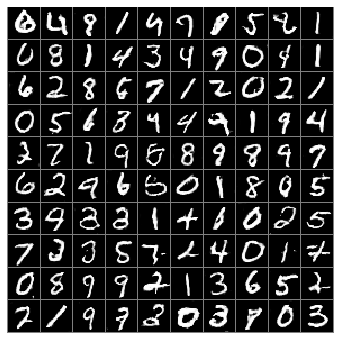

In [16]:
%matplotlib inline

oG.train(False)

mZ = torch.randn(100, oG.D, device=DEVICE)
with torch.no_grad():
    mFake = (oG(mZ).cpu() + 1) / 2
mGrid = torchvision.utils.make_grid(mFake, nrow=10, pad_value=1/2, padding=1)
mGrid = mGrid.permute(1,2,0)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(mGrid, cmap='gray')
ax.axis   ('off')
plt.show  ()

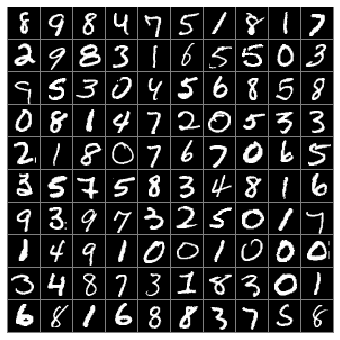

In [17]:
mGrid = torchvision.utils.make_grid((mX[:100] + 1) / 2, nrow=10, pad_value=1/2, padding=1)
mGrid = mGrid.permute(1,2,0)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(mGrid, cmap='gray')
ax.axis   ('off')
plt.show  ()